# Analysis figures for Transfer Learning model




The transfer learning model is a black-box CNN with inception, bidirectional, attention operators. 

Outputs from the CNN backbone is a vector, which is then linear-transformed to the same length of KINN intermediate rates, then added to the base rates as modifiers from sequence contexts.

$\delta_s =  f_{CNN}(seq) \cdot W +b$

$k = f_{KINN}(diff)$

$\hat{k} = k + \delta_s$


$\hat{k}_{eff} = KingAltman(\hat{k})$

$k_{eff} = KingAltman(k)$

Its effect, $\delta_s$, to the final model output $\hat{k}_{eff}$ is conditional on the base KINN intermediate kinetic rates $k$.

Therefore, it makes more sense to analyze the intermediate rate modifiers $\delta_s$, as outputed by CNN backbone, instead of the final KINN outputs $\hat{k}_{eff}$, and when $\delta_s$ is big enough such that $|\hat{k}_{eff} - k_{eff}| > \epsilon$.


In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
import tensorflow as tf
import shap
import h5py
import numpy as np
import pandas as pd
import os
import scipy.stats as ss
import src
from src.transfer_learn import KinnLayer, amber_app
from src.reload import reload_from_dir
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import defaultdict
from tqdm.notebook import tqdm
%matplotlib inline

Using TensorFlow backend.


In [3]:
if os.path.isdir("weights"):
    os.rmdir("weights")
amb = amber_app(wd=".", run=False)
# clean up folders created by trainEnv
os.rmdir("weights")

BUILDING
----------


2023-10-18 02:02:34,376 - AMBER - INFO -
 time budget set to: 72:00:00


controller = GeneralController
modeler = <class 'src.transfer_learn.TransferKinnModelBuilder'>
knowledge = zero
reward = LossAucReward
manager = GeneralManager
env_type = ControllerTrainEnv


In [4]:
# I'll make this hard-coded for now for faster reproducibility
# for how this table is generated, see `11-TL_model_analysis-Valid_v_Test.ipynb`
benchmark_df = pd.read_table("./outputs/analysis/transfer_learn.incremental_benchmark.tsv")
benchmark_df

,Kleinsitver,Listgarten,Listgarten_Indel,Valid,step,n_models,indv_perform,arc,trial,wd
0,0.188933,0.140707,0.208201,0.437008,0,1,"[0.189, 0.141, 0.208]","[0, 1, 5, 0, 0, 0, 1]",480,outputs/2022-11-01/TL_5
1,0.324715,0.195480,0.278344,0.439494,1,2,"[0.287, 0.188, 0.304]","[0, 2, 5, 0, 0, 0, 5]",494,outputs/2022-11-01/TL_3
2,0.316479,0.228706,0.352824,0.442244,2,3,"[0.242, 0.122, 0.247]","[1, 1, 5, 1, 1, 0, 5]",484,outputs/2022-11-01/TL_2
3,0.325627,0.222703,0.301412,0.442706,3,4,"[0.225, 0.127, 0.146]","[1, 2, 5, 0, 1, 0, 1]",494,outputs/2022-11-01/TL_1
4,0.364205,0.261566,0.324285,0.445176,4,5,"[0.186, 0.119, 0.171]","[0, 1, 1, 2, 1, 0, 3]",481,outputs/2022-11-01/TL_4


In [5]:
# load models
model_ensemble = []
for _, row in tqdm(benchmark_df.iterrows(), total=len(benchmark_df)):
    arc_seq = eval(row['arc'])
    target_wd = row['wd']
    best_trial_id = row['trial'] 
    #print(type(arc_seq))
    model = amb.model_fn(arc_seq)
    model.load_weights(os.path.join(target_wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"))
    model_ensemble.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
# load data
with h5py.File("./data/inVivoData.newValidSplit.h5", "r") as store:
    t1 = store["test/Kleinsitver_mut/x"][()], store["test/Kleinsitver_mut/y"][()]
    t2 = store["test/Listgarten_mut/x"][()], store["test/Listgarten_mut/y"][()]
    t3 = store["test/Listgarten_indel/x"][()], store["test/Listgarten_indel/y"][()]
    valid_data = store["valid/x"][()], store["valid/y"][()]
    kin_data = store["kinetic/x"][()], store["kinetic/y"][()], store["kinetic/k"][()]

data_cache = {
    'kleinsitver': t1,
    'listgarten': t2,
    'listgarten_indel': t3,
    'valid': valid_data,
    'kinetic': kin_data
}

In [7]:
# reproduce revised MS number
from keras import backend as K
trainable_count = [int(
    np.sum([K.count_params(p) for p in set(model_ensemble[i].trainable_weights)])) for i in range(5)]
print(f"trainable_count={np.mean(trainable_count)}+-{np.std(trainable_count)}")

trainable_count=154148.6+-76159.71739863534


In [8]:
y_pred = model_ensemble[-1].predict(t1[0], batch_size=25000)

In [9]:
y_pred2 = model_ensemble[0].predict(t1[0], batch_size=25000)

In [10]:
ss.spearmanr(y_pred, y_pred2)

SpearmanrResult(correlation=0.5627547085164157, pvalue=0.0)

In [11]:
model = model_ensemble[0]

In [12]:
# get each model's intermediate layer results
def get_intermediate_kinetic_model(model, include_kinn=True):
    layer_dict = {l.name:l for l in model.layers}
    k_layer_name = [x for x in layer_dict if x.startswith("kinn_")][0]
    # kinetic model: get intermediate outputs, e.g. predicted cleavage rate, seq delta, etc.
    kinetic_model = tf.keras.models.Model(
        inputs = model.inputs,
        outputs = [layer_dict[k_layer_name].output, layer_dict[k_layer_name].lin_transform.output] if include_kinn \
        else layer_dict[k_layer_name].lin_transform.output
    )
    return kinetic_model

def get_model_intermediate_outs(model, data):
    layer_dict = {l.name:l for l in model.layers}
    k_layer_name = [x for x in layer_dict if x.startswith("kinn_")][0]
    kinetic_model = get_intermediate_kinetic_model(model)
    # old_pred_ks: base KINN intermediate rates
    old_pred_ks = layer_dict[k_layer_name].kinn_header.predict(layer_dict[k_layer_name].mb.blockify_seq_ohe(data[:, :, 4:]))
    # pred_k: new cleavage rate
    # delta_seq: sequence delta
    pred_k, delta_seq = kinetic_model.predict(data)
    sess = tf.keras.backend.get_session()
    # old_pred_k: old cleavage_rate
    old_pred_k = sess.run(layer_dict[k_layer_name].kinn_body(old_pred_ks)).flatten()
    return {
        "old_ks": old_pred_ks,
        "old_clv": old_pred_k,
        "delta_seq": delta_seq,
        "new_ks": old_pred_ks + delta_seq,
        "new_clv": pred_k.flatten(),
    }


In [13]:
reload_res_from_disk = True
if reload_res_from_disk and os.path.isfile("./outputs/analysis/transfer_learning.model_intermediate.pkl"):
    with open("./outputs/analysis/transfer_learning.model_intermediate.pkl", "rb") as f:
        res = pickle.load(f)
else:
    res = {}
    for model_id in range(len(model_ensemble)):
        for data_id in data_cache:
            print(model_id, data_id)
            tmp = get_model_intermediate_outs(model=model_ensemble[model_id], data=data_cache[data_id][0])
            res[(model_id, data_id)] = tmp

    with open("./outputs/analysis/transfer_learning.model_intermediate.pkl", "wb") as f:
        pickle.dump(res, f)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


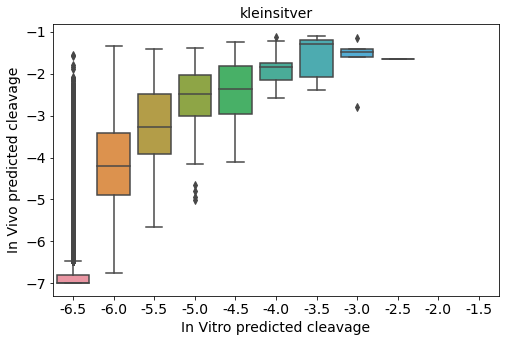

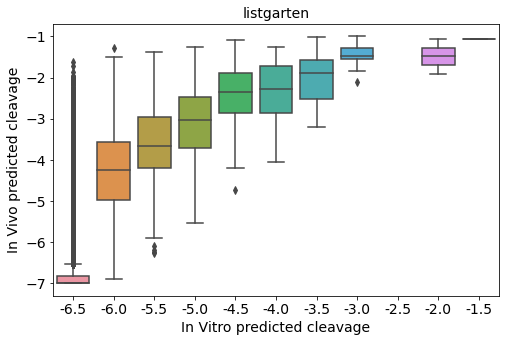

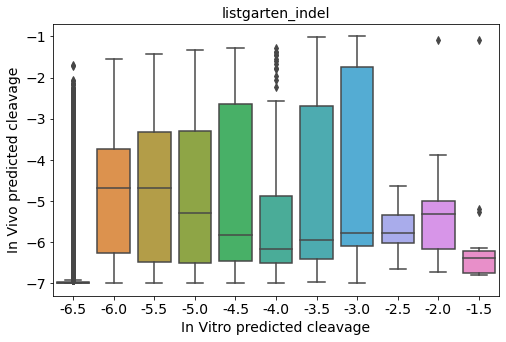

In [14]:
dfs = {}
for data_id in ['kleinsitver', 'listgarten', 'listgarten_indel']:
    in_vitro_clv = []
    in_vivo_clv = []
    for model_id in range(5):
        tmp = res[(model_id, data_id)]
        in_vitro_clv.append(tmp['old_clv'])
        in_vivo_clv.append(tmp['new_clv'])
    df = pd.DataFrame({
        'in_vitro_clv': np.array(in_vitro_clv).mean(axis=0), 
        'in_vivo_clv': np.array(in_vivo_clv).mean(axis=0)})
    df['in_vitro_clv_bin'] = pd.cut(df['in_vitro_clv'], [-7.1] + np.arange(-6.5, -1, 0.5).tolist())
    dfs[data_id] = df
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    sns.boxplot(x='in_vitro_clv_bin', y='in_vivo_clv', data=df, ax=ax)
    _ = ax.set_xticklabels(np.arange(-6.5, -1, 0.5).tolist())
    ax.set_title(data_id)
    ax.set_xlabel('In Vitro predicted cleavage')
    ax.set_ylabel('In Vivo predicted cleavage')
    # save to source_data
    df.to_csv(f'source_data/Fig4_{data_id}.csv', )

In [15]:
data_id = 'kleinsitver'
#data_id = 'listgarten'
#data_id = 'listgarten_indel'
dfs[data_id]['y_obs'] = data_cache[data_id][1]
diff_df = dfs[data_id].query("in_vitro_clv< -5 and in_vivo_clv> -2 and y_obs==1")
diff_df

,in_vitro_clv,in_vivo_clv,in_vitro_clv_bin,y_obs
95789,-5.553682,-1.763735,"(-6.0, -5.5]",1
95791,-5.753591,-1.636075,"(-6.0, -5.5]",1
95794,-5.356524,-1.774548,"(-5.5, -5.0]",1
95796,-5.196607,-1.906012,"(-5.5, -5.0]",1
95797,-5.715512,-1.848067,"(-6.0, -5.5]",1
95803,-6.625443,-1.551159,"(-7.1, -6.5]",1
95810,-5.305200,-1.387211,"(-5.5, -5.0]",1
95811,-5.172741,-1.750070,"(-5.5, -5.0]",1
95815,-5.055985,-1.504634,"(-5.5, -5.0]",1
95816,-6.894896,-1.888164,"(-7.1, -6.5]",1


In [16]:
# sanity check
from sklearn import metrics
print(
    metrics.average_precision_score(dfs[data_id]['y_obs'], dfs[data_id]['in_vivo_clv']),
    metrics.average_precision_score(dfs[data_id]['y_obs'], dfs[data_id]['in_vitro_clv']),
)

0.3616882263629 0.22789077430342408


In [17]:
def permute_seq(model, x):
    score = np.zeros((25,4))
    old = model.predict(x[np.newaxis, ...])
    for i in range(25):
        for j in range(4):
            _x = x.copy()
            _x[i, 0:4] = 0
            _x[i,j] = 1
            new = model.predict(_x[np.newaxis, ...])
            score[i,j] = new - old
    return score

"""
score = permute_seq(model, data_cache['kleinsitver'][0][diff_df.index[0]])
fig, ax = plt.subplots(1,1, figsize=(12,5))
rdgn = sns.diverging_palette(h_neg=220, h_pos=0, s=99, l=70, sep=10, n=10, as_cmap=True)
sns.heatmap(score.T, center=0, cmap=rdgn, ax=ax)
"""

"\nscore = permute_seq(model, data_cache['kleinsitver'][0][diff_df.index[0]])\nfig, ax = plt.subplots(1,1, figsize=(12,5))\nrdgn = sns.diverging_palette(h_neg=220, h_pos=0, s=99, l=70, sep=10, n=10, as_cmap=True)\nsns.heatmap(score.T, center=0, cmap=rdgn, ax=ax)\n"

In [18]:
def get_base_kinn_model(model):
    layer_dict = {l.name:l for l in model.layers}
    k_layer_name = [x for x in layer_dict if x.startswith("kinn_")][0]
    seq_ohe = model.inputs[0]
    seq_ohe = tf.gather(seq_ohe, layer_dict[k_layer_name].channels, axis=-1)
    inp_list = layer_dict[k_layer_name].mb.blockify_seq_ohe(seq_ohe)
    kinn_rates = layer_dict[k_layer_name].kinn_header(inp_list)
    clv = layer_dict[k_layer_name].kinn_body(kinn_rates)
    kinetic_model = tf.keras.models.Model(
        inputs = model.inputs,
        outputs = clv
    )
    return kinetic_model

In [19]:
def get_shap(model, kinn, x):
    bg_seq = np.zeros((1,25,13))
    e=shap.GradientExplainer(model, bg_seq, batch_size=25000)
    e2=shap.GradientExplainer(kinn, bg_seq, batch_size=25000)
    res = e.shap_values(X=x)
    res2 = e2.shap_values(X=x)
    diff = (res[0]/np.abs(res[0]).max()-res2[0]/np.abs(res2[0]).max()).squeeze().T
    diff = diff/np.abs(diff).max()
    return res[0], res2[0], diff

def get_diff_df(data_id):
    dfs[data_id]['y_obs'] = data_cache[data_id][1]
    diff_df = dfs[data_id].query("in_vitro_clv< -5 and in_vivo_clv> -2 and y_obs==1")
    diff_df['clv_diff'] = diff_df['in_vitro_clv'] - diff_df['in_vivo_clv']
    return diff_df.sort_values('clv_diff', ascending=True)



In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib import colors


def mat_to_seq(annot):
    letters = list('ACGT')
    seq_ohe = annot[:, 0:4]
    s = [letters[np.where(x)[0][0]] if np.sum(x)==1 else 'N' for x in seq_ohe]
    return s


def heatmap_with_circle(s, c, annot, remove_indel=False):
    N = 13 if remove_indel is False else 8
    M = 25
    letters = 'ACGT'
    ylabels = list(letters) + ['s-%s'%x for x in letters]
    if remove_indel: 
        s = s[0:8]
        c = c[0:8]
    else:
        ylabel +=  ['i-%s'%x for x in letters] + ['d']
    #xlabels = np.arange(1, M+1)
    xlabels = mat_to_seq(annot)

    x, y = np.meshgrid(np.arange(M), np.arange(N))
    #s = np.random.randint(0, 180, size=(N,M))
    #c = np.random.rand(N, M)-0.5

    fig, ax = plt.subplots(1,1,figsize=(12,5))

    R = s/s.max()/2
    circles = [plt.Circle((j,i), radius=r, alpha=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
    rdgn = sns.diverging_palette(h_neg=220, h_pos=0, s=99, l=70, sep=10, n=10, as_cmap=True)
    divnorm=colors.TwoSlopeNorm(vmin=-0.5, vcenter=0., vmax=0.5)
    col = PatchCollection(circles, array=c.flatten(), cmap=rdgn, norm=divnorm)
    ax.add_collection(col)

    ax.set(xticks=np.arange(M), yticks=np.arange(N),
           xticklabels=xlabels, yticklabels=ylabels)
    ax.set_xticks(np.arange(M+1)-0.5, minor=True)
    ax.set_yticks(np.arange(N+1)-0.5, minor=True)
    ax.grid(which='minor')

    fig.colorbar(col)
    plt.gca().invert_yaxis()
    return fig, ax

In [21]:
reload_shaps_from_disk = True
shaps = {}
if reload_shaps_from_disk and os.path.isfile('./outputs/analysis/transfer_learning.shaps.pkl'):
    with open('./outputs/analysis/transfer_learning.shaps.pkl', 'rb') as f:
        shaps = pickle.load(f)
else:
    for data_id in ['kleinsitver', 'listgarten', 'listgarten_indel']:
        diff_df = get_diff_df(data_id)
        for model_id, model in enumerate(model_ensemble):
            print(model_id)
            model = model_ensemble[model_id]
            kinn = get_base_kinn_model(model)
            for idx in tqdm(diff_df.index):
                x=data_cache[data_id][0][[idx]]
                res, res2, diff = get_shap(model, kinn, x)
                shaps[(model_id, data_id, idx)] = diff

    with open('./outputs/analysis/transfer_learning.shaps.pkl', 'wb') as f:
        pickle.dump(shaps, f)

In [22]:
# concat shaps by datapoints
shaps_agg = {}
_shaps_agg = defaultdict(list)
for k, diff in shaps.items():
    model_id, data_id, idx = k
    if np.isnan(diff.sum()):
        continue
    _shaps_agg[(data_id, idx)].append(diff)

for k,v in _shaps_agg.items():
    tmp = np.array(_shaps_agg[k])
    shaps_agg[k] = tmp.mean(axis=0), 1/(tmp.var(axis=0)+0.1)

In [23]:
letter_contrib = [[], [], [], []]
letter_vars = [[], [], [], []]
for k in shaps_agg:
    for i in range(4):
        tmp = shaps_agg[k][0][i]
        tmp2 = shaps_agg[k][1][i]
        letter_contrib[i].extend(tmp[tmp!=0].tolist())
        letter_vars[i].extend(tmp2[tmp!=0].tolist())

Text(0, 0.5, 'Log10(Var_Shap)')

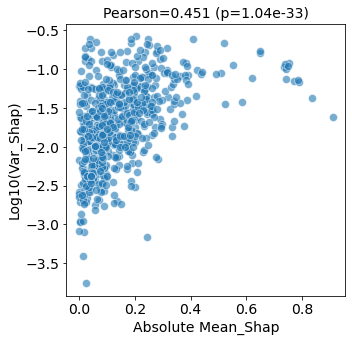

In [24]:
# see the correlation between contrib vs across-model variance
fig, ax = plt.subplots(1,1,figsize=(5,5))
c = [np.abs(x) for _ in letter_contrib for x in _]
s = [np.log10(1/x-0.1) for _ in letter_vars for x in _]
sns.scatterplot(x=c, y=s, alpha=0.6)
ax.set_title("Pearson=%.3f (p=%.2e)" % ss.pearsonr(c,s))
ax.set_xlabel('Absolute Mean_Shap')
ax.set_ylabel('Log10(Var_Shap)')

In [25]:
def box_and_whisker(data, title, ylabel, xticklabels, test_combinations=None):
    """
    Function from: https://rowannicholls.github.io/python/graphs/ax_based/boxplots_significance.html
    Create a box-and-whisker plot with significance bars.
    """
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    bp = ax.boxplot(data, widths=0.6, patch_artist=True)
    # Graph title
    ax.set_title(title, fontsize=14)
    # Label y-axis
    ax.set_ylabel(ylabel)
    # Label x-axis ticks
    ax.set_xticklabels(xticklabels)
    # Hide x-axis major ticks
    ax.tick_params(axis='x', which='major', length=0)
    # Show x-axis minor ticks
    xticks = [0.5] + [x + 0.5 for x in ax.get_xticks()]
    ax.set_xticks(xticks, minor=True)
    # Clean up the appearance
    ax.tick_params(axis='x', which='minor', length=3, width=1)

    # Change the colour of the boxes to Seaborn's 'pastel' palette
    colors = sns.color_palette('pastel')
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # Colour of the median lines
    plt.setp(bp['medians'], color='k')

    # Check for statistical significance
    test_combinations = test_combinations or []
    significant_combinations = []
    # Check from the outside pairs of boxes inwards
    ls = list(range(1, len(data) + 1))
    combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
    for c in combinations:
        if len(test_combinations) and not c in test_combinations:
            print(f"skipped test {c}")
            continue
        data1 = data[c[0] - 1]
        data2 = data[c[1] - 1]
        # Significance
        U, p = ss.mannwhitneyu(data1, data2, alternative='two-sided')
        if p < 0.05:
            significant_combinations.append([c, p])

    # Get info about y-axis
    bottom, top = ax.get_ylim()
    yrange = top - bottom

    # Significance bars
    for i, significant_combination in enumerate(significant_combinations):
        # Columns corresponding to the datasets of interest
        x1 = significant_combination[0][0]
        x2 = significant_combination[0][1]
        # What level is this bar among the bars above the plot?
        level = len(significant_combinations) - i
        # Plot the bar
        bar_height = (yrange * 0.08 * level) + top
        bar_tips = bar_height - (yrange * 0.02)
        plt.plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
        # Significance level
        p = significant_combination[1]
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'
        text_height = bar_height + (yrange * 0.01)
        plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', c='k')

    # Adjust y-axis
    bottom, top = ax.get_ylim()
    yrange = top - bottom
    ax.set_ylim(bottom - 0.02 * yrange, top)

    # Annotate sample size below each box
    for i, dataset in enumerate(data):
        sample_size = len(dataset)
        ax.text(i + 1, bottom, fr'n = {sample_size}', ha='center', size='large')

    plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


skipped test (1, 4)
skipped test (2, 4)
skipped test (1, 2)


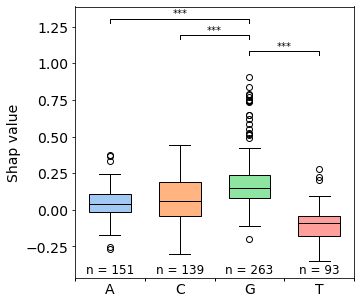

In [26]:
# Analyze ACGT shap values
box_and_whisker(
    letter_contrib, title='', 
    ylabel='Shap value', xticklabels=['A','C','G','T'],
    test_combinations=[(1,3),(2,3),(3,4)]
)

Text(0, 0.5, 'SHAP value')

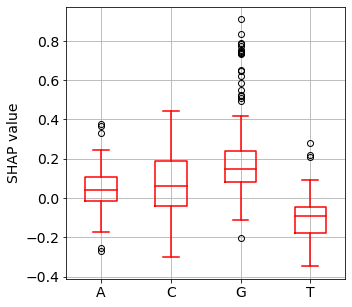

In [27]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
df = pd.DataFrame(letter_contrib, index=['A','C','G','T']).T
ax = df.plot(kind='box', ax=ax,
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             #flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=True, grid=True, rot=0)
ax.set_ylabel('SHAP value')

('kleinsitver', 95817)


<AxesSubplot:>

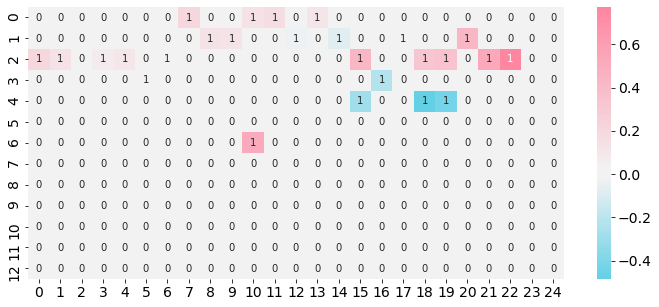

In [28]:
ks = [k for k in shaps_agg]
k = ks[2]
print(k)
# plain plot from seaborn for sanity checks
x = data_cache[k[0]][0][k[1]]
fig, ax = plt.subplots(1,1, figsize=(12,5))
rdgn = sns.diverging_palette(h_neg=220, h_pos=0, s=99, l=70, sep=10, n=10, as_cmap=True)
sns.heatmap(shaps_agg[k][0], annot=x.squeeze().T, center=0, cmap=rdgn, ax=ax)

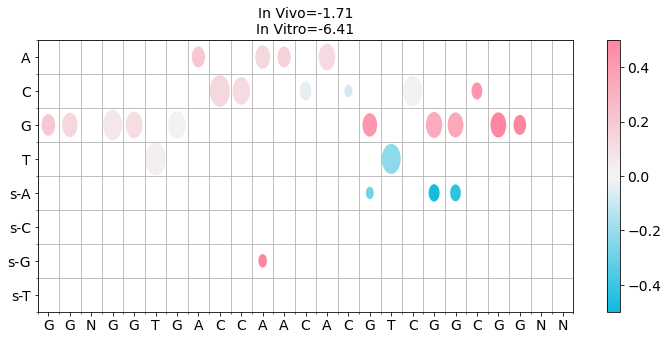

In [29]:

# Example 1: largest diff
k = ks[2]
c = shaps_agg[k][0].copy()
c[c==0] = np.nan
s = shaps_agg[k][1]
annot = data_cache[k[0]][0][k[1]]
fig, ax = heatmap_with_circle(c=c, s=s, annot=annot, remove_indel=True)
ax.set_title("In Vivo=%.2f\nIn Vitro=%.2f" % (dfs[k[0]].loc[k[1], 'in_vivo_clv'], dfs[k[0]].loc[k[1], 'in_vitro_clv'], ))
# save to source_data
dd = []
for i in range(8):
    dd.append([])
    for j in range(len(c[i])):
        # Combine the corresponding entries in mean and variance
        combined_entry = f'{round(c[i, j],3)} ({round(s[i, j],3)})'
        if np.isnan(c[i, j]): combined_entry = '-'
        # Add the combined entry to the new data frame
        dd[i].append(combined_entry)
dd = pd.DataFrame(dd, index=['A','C','G','T','s-A','s-C','s-G','s-T'], columns=mat_to_seq(annot))
dd.to_csv('source_data/Fig4C_1.csv')

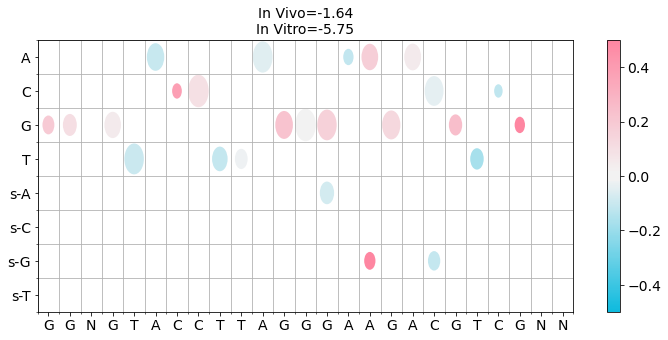

In [30]:
# Example 2: largest diff
k = ks[3]
c = shaps_agg[k][0].copy()
c[c==0] = np.nan
s = shaps_agg[k][1]
annot = data_cache[k[0]][0][k[1]]
fig, ax = heatmap_with_circle(c=c, s=s, annot=annot, remove_indel=True)
ax.set_title("In Vivo=%.2f\nIn Vitro=%.2f" % (dfs[k[0]].loc[k[1], 'in_vivo_clv'], dfs[k[0]].loc[k[1], 'in_vitro_clv'], ))

# save to source_data
dd = []
for i in range(8):
    dd.append([])
    for j in range(len(c[i])):
        # Combine the corresponding entries in mean and variance
        combined_entry = f'{round(c[i, j],3)} ({round(s[i, j],3)})'
        if np.isnan(c[i, j]): combined_entry = '-'
        # Add the combined entry to the new data frame
        dd[i].append(combined_entry)
dd = pd.DataFrame(dd, index=['A','C','G','T','s-A','s-C','s-G','s-T'], columns=mat_to_seq(annot))
dd.to_csv('source_data/Fig4C_2.csv')

In [31]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Oct 18 2023

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

src       : 0.0.3
pandas    : 1.0.3
shap      : 0.41.0
sklearn   : 0.0
tensorflow: 1.15.0
numpy     : 1.19.5
seaborn   : 0.11.1
h5py      : 2.10.0
scipy     : 1.7.3
keras     : 2.2.5
matplotlib: 3.4.3

Watermark: 2.3.1

